In [1056]:
#Imports
import pickle
import numpy as np
import os 
import matplotlib.pyplot as plt

# ADVANCED FEATURE CONTROL
USE_ALL_DATA = False
EARLY_STOPPING = False
DECAY_RATE = False
DECAY_RATE_VALUE = 0.85
XAVIER = False
SVM = False

# Load data functions
# Functions from Cifar page
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadLabels(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        return [x.decode('ascii') for x in data[b'label_names']]
    
def intToLabel(a):
    strs = ["" for x in range(len(a))]
    for i in range(len(a)):
        strs[i] = labels[a[i]]
    return strs
    
def batchToObject(batch):
    
    convertToText = np.transpose(np.array(batch[b'labels']))
    for i in range(len(batch[b'labels'])):
        zeroVector = np.zeros((10,1))
        zeroVector[batch[b'labels'][i]] = 1
        batch[b'labels'][i] = np.transpose(zeroVector)[0].astype(int)
    # Create new dictionaries
    batchAsObject =  {
        'images': np.divide(batch[b'data'], 255),
        'label':  np.array(batch[b'labels']),
        'labelText': intToLabel(convertToText)
    }
    return batchAsObject

In [1057]:
# Destination to dataset
dataDir = "C:/Users/ottarg/Desktop/KTH_PROGRAM/4-Deep Learning/Assignments/DataSets"

# Load labels
labelDir = dataDir + "/batches.meta"
labels = loadLabels(labelDir)

# Load sets
if(USE_ALL_DATA):
    training1 = batchToObject(unpickle(dataDir + "/data_batch_1"))
    training2 = batchToObject(unpickle(dataDir + "/data_batch_2"))
    training3 = batchToObject(unpickle(dataDir + "/data_batch_3"))
    training4 = batchToObject(unpickle(dataDir + "/data_batch_4"))
    training5 = batchToObject(unpickle(dataDir + "/data_batch_5"))
    
    # lenOfBatch
    lb = 10000
    #restForVali
    rV = 200
    #sliceIndex
    sl = lb- rV
    training = {
        'images': np.vstack((training1['images'][0:sl], training2['images'][0:sl], training3['images'][0:sl], training4['images'][0:sl], training5['images'][0:sl])) ,
        'label': np.vstack((training1['label'][0:sl], training2['label'][0:sl], training3['label'][0:sl], training4['label'][0:sl], training5['label'][0:sl])) ,
        'labelText': np.vstack((training1['labelText'][0:sl], training2['labelText'][0:sl], training3['labelText'][0:sl], training4['labelText'][0:sl], training5['labelText'][0:sl])) ,
    }
    validate = {
        'images': np.vstack((training1['images'][sl:lb], training2['images'][sl:lb], training3['images'][sl:lb], training4['images'][sl:lb], training5['images'][sl:lb])) ,
        'label': np.vstack((training1['label'][sl:lb], training2['label'][sl:lb], training3['label'][sl:lb], training4['label'][sl:lb], training5['label'][sl:lb])) ,
        'labelText': np.vstack((training1['labelText'][sl:lb], training2['labelText'][sl:lb], training3['labelText'][sl:lb], training4['labelText'][sl:lb], training5['labelText'][sl:lb])) ,
    }
else:    
    training = batchToObject(unpickle(dataDir + "/data_batch_1"))
    validate = batchToObject(unpickle(dataDir + "/data_batch_2"))

testing = batchToObject(unpickle(dataDir + "/test_batch"))


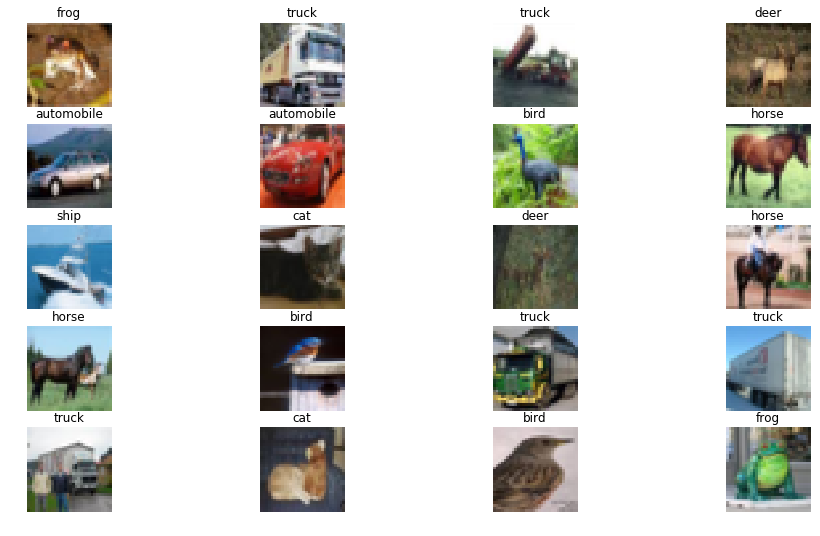

In [708]:


def dispImg(img, label):
    # ‘F’ means to read / write the elements using Fortran-like index order, 
    # with the first index changing fastest, and the last index changing slowest.
    loadImg = np.reshape(img, (32, 32, 3), order='F') 
    rotImg = np.rot90(loadImg, k=3) # change to 3 times?
    plt.rcParams["figure.figsize"] = [16,9]
    plt.imshow(rotImg)
    plt.axis('off')
    plt.title(label)

def plotManyImg(dataset,n,m):
    imgNo = 0
    for i in range(n*m): 
        plt.subplot(n, m, i+1)
        dispImg(dataset['images'][i], dataset['labelText'][i])
    plt.show()

plotManyImg(training,5,4)    


In [908]:
# Helping functions

# Softmax function
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# Cross entropy
def crossEntropy(X):
    m = len(X)
    logLikelihood = -np.log(X)
    loss = np.sum(logLikelihood) / m
    return loss

# Calculating functions

# Returns the net outcome and the winning index
def evaluateClassifier(inputData, inputLayer, weights, bias):
    # Calculate the softmax with dot product of weights and input
    calculateNetwork = np.dot(weights, inputData) + bias
    probab = softmax(calculateNetwork)
    return probab

def computeCost(probab, realLabel, outputNodes, weights, lambdaVal):
    # Multiply one hot array with probabilites to get only the winning weight
    winValue = np.multiply(realLabel, probab)
    # Reduce array to only contain winning value
    val = np.argmax(winValue, axis=0)
    sumValue = winValue.sum(axis=0)
    # Calculate cross-entropy loss
    # Add regularization
    regularization = lambdaVal * np.sum(np.power(weights, 2))
    crossEntropyLoss = crossEntropy(sumValue) + regularization
    return  crossEntropyLoss

def computeAccuracy(probab, realLabel):
    # Get the index of the real class
    # Select the winning(max value) index of each array
    predict = np.argmax(probab, axis=0)
    realLabel = np.argmax(realLabel, axis=0)
    # Count how many were actually correctly classified
    percOfCorrectlyClassified = (np.sum(predict == realLabel)) / len(realLabel)
    # Divide by number of elements to get percentage
    return percOfCorrectlyClassified 


In [1]:
# Here I'm checking the initial cost of the network and if the functions are correct
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
outputNodes = 10
weights = np.random.normal(0.0, 0.01, (outputNodes, inputNodes))
bias = np.random.normal(0.0, 0.01, (outputNodes, 1))
eta = 0
lambdaVal = 0.1

inputData = np.transpose(training['images'][0:3])
realLabel = np.transpose(training['label'][0:3])

probab = evaluateClassifier(inputData, inputNodes, weights, bias)

startingCost = computeCost(probab, realLabel, outputNodes, weights, lambdaVal)
acc = computeAccuracy(probab, realLabel)
print('Cost:', startingCost)
print('acc:', acc)

NameError: name 'np' is not defined

In [1063]:
# Bonus part 2
# Here I'm checking the initial cost of the network and if the functions are correct
def svmLossAndGrad(weights, inputData, realLabel, lambdaVal):
    # Change dimensions - had problem with dot products 
    weights = np.transpose(weights)
    
    inputData = np.transpose(inputData)
    nSamples = np.shape(inputData)[0]
    
    realLabel = np.transpose(realLabel)
    realLabel = np.argmax(realLabel, axis=1)
    # Initialse the change in weights
    weightsGradient = np.zeros(np.shape(weights))

    # compute the loss and the gradient
    totalCost = 0.0
    for i in range(nSamples):
        # For each class calculate the class value on the patterns
        classValue = inputData[i].dot(weights)
        correctClassValue = classValue[realLabel[i]]
        for j in range(10): # Got 10 classes
            if j != realLabel[i]:
                # Reduce the change between correct and predict
                addValue = max(0,classValue[j] - correctClassValue + 1)
                if addValue > 0:
                    totalCost += addValue
                    # update the weights based in the data pattern used
                    weightsGradient[:,j] += inputData[i]
                    weightsGradient[:,realLabel[i]] -= inputData[i] 
    # Get the gradient change and average loss
    totalCost = totalCost/ nSamples
    weightsGradient   = weightsGradient / nSamples
     # Add regularization 
    # NOTE: I couldn't find the regularization for the SVM in the lectures but I found this on some cs231 slides
    totalCost = totalCost + 0.5 * lambdaVal * np.sum(pow(weights,2))

    #Add regularization
    weightsGradient = weightsGradient + lambdaVal*weights
    return totalCost, np.transpose(weightsGradient)

np.random.seed(400)

inputNodes = 32*32*3 # 32*32*rgb
outputNodes = 10
weights = np.random.normal(0.0, 0.01, (outputNodes, inputNodes))
bias = np.random.normal(0.0, 0.0, (outputNodes, 1))
eta = 0
lambdaVal = 0.0

inputData = np.transpose(training['images'][0:3])
realLabel = np.transpose(training['label'][0:3])

a, b = svmLossAndGrad(weights, inputData, realLabel, lambdaVal)
print(a)

6.99482313601


In [713]:
# Gradient functions
# From assignment-"You should refer to the lecture notes for the explicit description of how to compute these gradients."
# From lecture 3, slide 82, bullet 1, the formula is defined as
# g = -(yT / (yT * p)) * (diag(p)) - ppT)
# which translates to python code
# gradVal = - np.dot(target, (np.diag(pVal) - np.outer(pVal, pVal))) / np.dot(target, pVal)
# but this can be simplified with g = y-p
# This loop is translated from lecture slide 84
def calculateGradient(inputData, probab, realLabel, weights, bias, lambdaVal):
    # Set all entries in @L/@b and @L/@W to zero.
    weightsGradient = np.zeros((10,np.shape(weights)[1]))
    biasGradient = np.zeros((10,np.shape(bias)[1]))
    # |D(t)|
    N = np.shape(probab)[1]
    # for each (x; y)
    for i in range(N):
        # Evaluate p - already have it
        pVal = probab[:, i]
        # X
        inputX = inputData[:, i]
        # y
        target = realLabel[:,i]
        # Let
        gradVal = pVal - target
        # Add gradient of l(x; y;W; b) w.r.t. b
        biasGradient += np.reshape(gradVal, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(gradVal, inputX)

    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N

    return weightsGradient, biasGradient

# Roughly translated from ComputeGradsNum.m
# TODO: Change/write slow version also?
def computeGradsNum(inputData, realLabel, inputNodes, weights,bias,h):
    
    weightsGradient = np.zeros((10,np.shape(weights)[1]))
    biasGradient = np.zeros((10,np.shape(bias)[1]))
    lambdaVal = 0
    # Calculate first cost
    probab = evaluateClassifier(inputData, inputNodes, weights,bias)
    totalCost = computeCost(probab, realLabel, outputNodes, weights, lambdaVal)

    for i in range(len(bias)):
        bias[i] = bias[i] + h
        # Calculate bias cost with h
        probab = evaluateClassifier(inputData, inputNodes, weights,bias)
        totalCost2 = computeCost(probab, realLabel, outputNodes, weights, lambdaVal)
        biasGradient[i] = (totalCost2 - totalCost) / h
        # NOTE: Have to remove the minVal again since the function is referencing the value again.  
        bias[i] = bias[i] - h

    for i in range(len(weights)):
        for j in range(weights.shape[1]):
            weights[i, j] = weights[i, j] + h
            # Calculate weight cost with h
            probab = evaluateClassifier(inputData, inputNodes, weights,bias)
            totalCost2 = computeCost(probab, realLabel, outputNodes, weights, lambdaVal)
            weightsGradient[i, j] = (totalCost2 - totalCost) / h
            # Also here
            weights[i, j] = weights[i, j] - h

    return weightsGradient, biasGradient



In [704]:
# Here I'm checking if the gradients are computed correctly
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
outputNodes = 10
weights = np.random.normal(0, 0.01, (outputNodes, inputNodes))
bias = np.random.normal(0.0, 0.01, (outputNodes, 1))
eta = 0

N = 100
inputData = np.transpose(training['images'][0:N])
realLabel = np.transpose(training['label'][0:N])

minVal = 1e-6 
# Calculate via Matlab function
weightsGradientNum, biasGradientNum = computeGradsNum(inputData, realLabel,inputNodes, weights, bias, minVal)
# Calculate accoring to formula from slides
probab = evaluateClassifier(inputData, inputNodes, weights, bias)
weightsGradient, biasGradient = calculateGradient(inputData, probab, realLabel, weights, bias, eta)



In [705]:
#Compare them
def compareDifferenation(weightsGradient, weightsGradientNum, biasGradient, biasGradientNum):
    minVal = 1e-6 
    
    # Compute the relative error of weights
    ga_gn = np.sum(np.abs(weightsGradient - weightsGradientNum))
    
    ga = np.sum(np.abs(weightsGradient))
    gn = np.sum(np.abs(weightsGradientNum))
    
    maxVal = max(minVal, ga + gn)
    
    weightCheck = ga_gn / maxVal
    print("The relative error of weights is " + str(weightCheck))
    
    # Compute the relative error of bias
    ga_gn = np.sum(np.abs(biasGradient - biasGradientNum))
    
    ga = np.sum(np.abs(biasGradient))
    gn = np.sum(np.abs(biasGradientNum))
    
    maxVal = max(minVal, ga + gn)
    
    biasCheck = ga_gn / maxVal
    print("The relative error of bias is " + str(biasCheck))

compareDifferenation(weightsGradient, weightsGradientNum, biasGradient, biasGradientNum)

# From first hundred I got weights 3.53672416359e-07 and bias 6.25794375978e-07
# The number is pretty small, so I think I can continue here

The relative error of weights is 3.53672416346e-07
The relative error of bias is 6.25794376012e-07


In [1058]:
# I know they are correctly calculated so I can proceed with the training
from copy import deepcopy
def train(inputNodes, outputNodes, weights, bias, trainData, validData, eta, epochs, batchSize, lambdaVal):
    
    nOfSamples = len(trainData['images'])
    nOfBatch = int(nOfSamples / batchSize)
    
    inputData = np.transpose(trainData['images'])
    realLabel = np.transpose(trainData['label'])
    
    val_inputData = np.transpose(validData['images'])
    val_realLabel = np.transpose(validData['label'])
     
    accuracyTraining = []
    accuracyValidation = []
    costTraining = []
    costValidation = []
    
    for epoch in range(epochs):
        print("Epoch: " + str(epoch))
        for i in range(nOfBatch):
            # Prepare batch
            startOfBatch = i * batchSize
            endOfBatch = (i+1) * batchSize
            batch_inputData = np.transpose(trainData['images'][startOfBatch:endOfBatch])
            batch_realLabel = np.transpose(trainData['label'][startOfBatch:endOfBatch])

            # Update weights
            if(SVM):
                _, grad = svmLossAndGrad(weights, batch_inputData, batch_realLabel, lambdaVal)
                weights -= eta * grad
            else:
                probab = evaluateClassifier(batch_inputData, inputNodes, weights,bias)
                weightsGradient, biasGradient = calculateGradient(batch_inputData, probab, batch_realLabel, weights, bias, lambdaVal)
                bias -= eta * biasGradient
                weights -= eta * weightsGradient
        
        probab = evaluateClassifier(inputData, inputNodes, weights,bias)
        val_probab = evaluateClassifier(val_inputData, inputNodes, weights,bias)

        if(SVM):
            totalCost, _ = svmLossAndGrad(weights, inputData, realLabel, lambdaVal)
            val_totalCost, _ = svmLossAndGrad(weights, val_inputData, val_realLabel, lambdaVal)
        else:
            
            totalCost = computeCost(probab, realLabel, outputNodes, weights, lambdaVal)
            val_totalCost = computeCost(val_probab, val_realLabel, outputNodes, weights, lambdaVal)
            
        # How many in the training set are correctly classified
        totalAccuracy = computeAccuracy(probab, realLabel)

        # How many in the validation set are correctly classified based on the training set
        val_totalAccuracy = computeAccuracy(val_probab, val_realLabel)
        
        # Decay by the end of the loop
        if DECAY_RATE:
            eta *= DECAY_RATE_VALUE 
        # Do early stopping if used. Use some sort of threshold, we can play around with this
        # TODO: Stop if the error difference is greater then 0.019
        stopThreshold = 0.019
        if(EARLY_STOPPING):
            diffCost = np.abs(totalCost-val_totalCost)
            if(diffCost > stopThreshold):
                print("Early stopping detected at epoch " + str(epoch) + " with value " + str(diffCost))
                break
        
        # Add to list
        accuracyTraining.append(totalAccuracy)
        accuracyValidation.append(val_totalAccuracy)
        
        costTraining.append(totalCost)
        costValidation.append(val_totalCost)

    print("Done")
    return accuracyTraining, accuracyValidation, costTraining, costValidation

In [868]:
# Info functions for report

def printInfo(training, validation, test, inputNodes, weights,bias, outputNodes, eta):
   
    probab = evaluateClassifier(np.transpose(training['images']), inputNodes, weights,bias)
    finalAccuracy = computeAccuracy(probab, np.transpose(training['label']))
    finalCost = computeCost(probab, np.transpose(training['label']), outputNodes, weights, lambdaVal)
    print("Info on Training data: Accuracy: " + str(round(finalAccuracy*100,2)) + "% and Cost: " + str(round(finalCost,2) ))

    probab = evaluateClassifier(np.transpose(validation['images']), inputNodes, weights,bias)
    val_finalCost = computeCost(probab, np.transpose(validation['label']), outputNodes, weights, lambdaVal)
    val_finalAccuracy = computeAccuracy(probab, np.transpose(validation['label']))
    print("Info on Validation data: Accuracy: " + str(round(val_finalAccuracy*100,2)) + "% and Cost: " + str(round(val_finalCost,2) ))

    probab = evaluateClassifier(np.transpose(test['images']), inputNodes, weights,bias)
    test_finalCost = computeCost(probab, np.transpose(test['label']), outputNodes, weights, lambdaVal)
    test_finalAccuracy = computeAccuracy(probab, np.transpose(test['label']))
    print("Info on Testing data: Accuracy: " + str(round(test_finalAccuracy*100,2)) + "% and Cost: " + str(round(test_finalCost,2) ))

          
def plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation ):
    plt.plot(costTraining, label='Training cost')
    plt.plot(costValidation, label='Validation cost')
    plt.legend()
    
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Cost')
    plt.show()
    plt.plot(accuracyTraining, label='Training acc')
    plt.plot(accuracyValidation, label='Validation acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.show()

def normalize(weightMatrix):
    maxVal = np.max(weightMatrix)
    minVal = np.min(weightMatrix)
    return (weightMatrix - minVal) / (maxVal - minVal)

def plotweights(W,label):
    for i, row in enumerate(W):
        imgNormalized = normalize(row) # ValueError: Floating point image RGB values must be in the 0..1 range.
        plt.subplot(5, 2, i+1)
        dispImg(imgNormalized, labels[i])
    plt.show()
    



In [1059]:
# Train the networks here

np.random.seed(400)
inputNodes = 32*32*3 # 32*32*rgb
outputNodes = 10

if(XAVIER):
    # Initialize xavier
    variance = 1 / np.sqrt(inputNodes)
    weights = np.random.normal(0, pow(variance,2), (outputNodes, inputNodes))
else:
    weights = np.random.normal(0, 0.01, (outputNodes, inputNodes))

bias = np.random.normal(0.0, 0.0, (outputNodes, 1))

# Values to test
#lambda=0, n epochs=40, n batch=100, eta=.1
#lambda=0, n epochs=40, n batch=100, eta=.01
#lambda=.1, n epochs=40, n batch=100, eta=.01
#lambda=1, n epochs=40, n batch=100, eta=.01

# Set the parameters here
eta = 0.01
epoch = 40
batch = 100
lambdaVal = 0

# run the training
accuracyTraining, accuracyValidation, costTraining, costValidation = train(inputNodes, outputNodes, weights, bias, training, validate, eta, epoch, batch, lambdaVal)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Done


Info on network with lambda=0 epochs=40 batch=100 eta=0.01
Info on Training data: Accuracy: 41.35% and Cost: 1.68
Info on Validation data: Accuracy: 36.49% and Cost: 1.82
Info on Testing data: Accuracy: 36.83% and Cost: 1.8


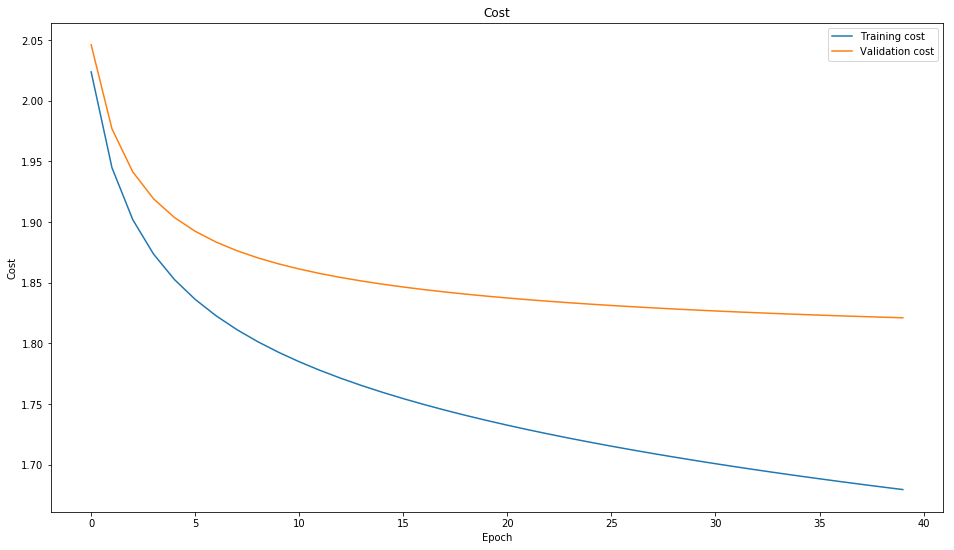

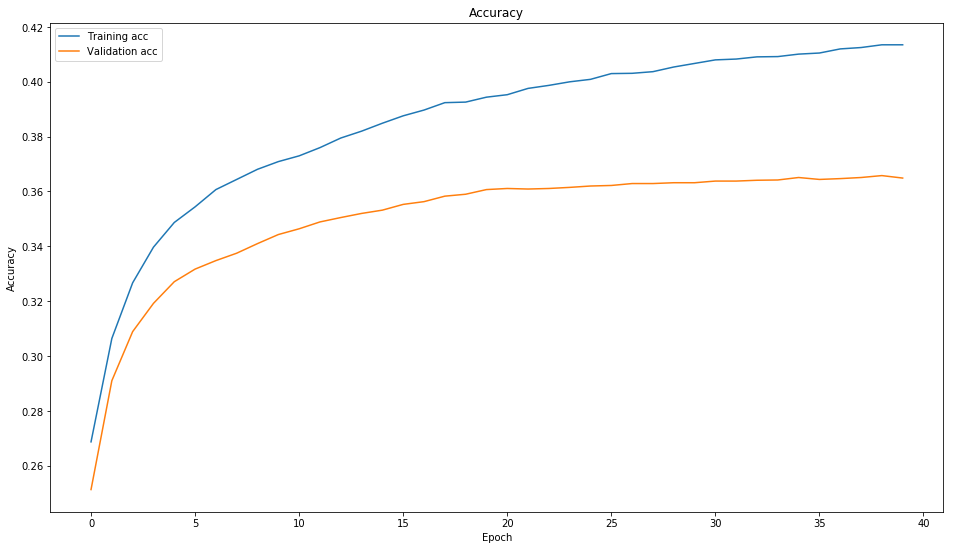

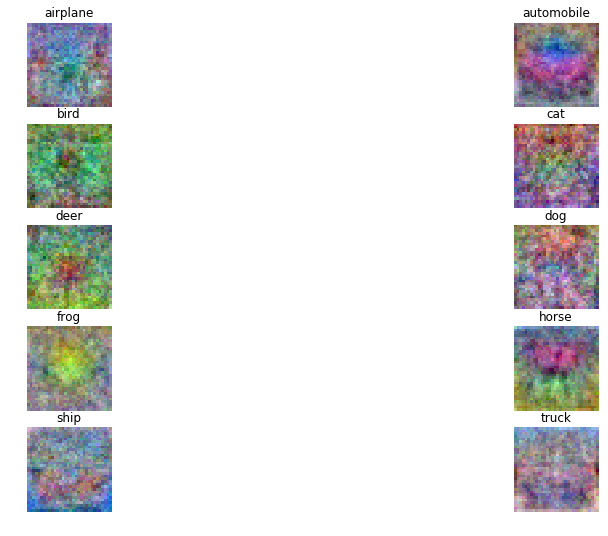

In [1062]:
# Run this cell after training to get the information about the trained network
def infoAboutNetwork():
    print("Info on network with lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) )
    printInfo(training, validate, testing, inputNodes, weights,bias, outputNodes, eta)
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )
    plotweights(weights, labels)
    
infoAboutNetwork()